### 1. Standardize and collapse the apartment API addresses.
### 2. Join the collapsed API addresses with FEMA data.
### 3. Find the nearest building footprint for each joined entry.

In [65]:
# Import all necessary libraries
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
%matplotlib inline
from shapely.geometry import Polygon
from shapely.geometry import Point,Polygon
from pyproj import Proj, Transformer
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3
import fiona
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import requests
import pandas as pd
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from shapely.ops import nearest_points
from pyproj import CRS
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from functools import lru_cache
import concurrent.futures
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
from sklearn.neighbors import BallTree
import numpy as np


#!pip install pyarrow
#!pip install geopy
#!pip install fiona

In [66]:
# Load FEMA Data
fema_data_path = '/Users/kd6801/Desktop/HI_map/HI_Structures.gdb'

# List all layers in the File Geodatabase
layers = fiona.listlayers(fema_data_path)

# Read a specific layer into a GeoDataFrame
fema_data = gpd.read_file(fema_data_path, layer=layers[0])


In [67]:
# Load API Data
api_data = pd.read_json('/Users/kd6801/Desktop/Hilo_API/Hilo_apartment.json')

In [68]:
# Load building footprint data
path_to_hilo_parquet = '/Users/kd6801/Desktop/foot-traffic/hilo_full_patterns.parquet'
building_footprints =  pd.read_parquet(path_to_hilo_parquet, engine='pyarrow')

In [69]:
api_data.iloc[2]

id                                    98-Ponahawai-St,-Hilo,-HI-96720
formattedAddress                      98 Ponahawai St, Hilo, HI 96720
addressLine1                                          98 Ponahawai St
addressLine2                                                     None
city                                                             Hilo
state                                                              HI
zipCode                                                         96720
county                                                         Hawaii
latitude                                                    19.722039
longitude                                                 -155.084752
propertyType                                                Apartment
squareFootage                                                  3942.0
lotSize                                                        4574.0
yearBuilt                                                      1919.0
assessorID          

In [70]:
building_footprints.iloc[1]

placekey                                                   22d-222@bp4-jct-f75
safegraph_place_id                         sg:e170329441704027b328f7603705729f
parent_placekey                                            228-222@bp4-jct-hkf
parent_safegraph_place_id                  sg:d4f8d56cb61345e6b33a5a1382a503d7
location_name                                  Happy Valley Seafood Restaurant
safegraph_brand_ids                                                       None
brands                                                                    None
top_category                               Restaurants and Other Eating Places
sub_category                                          Full-Service Restaurants
category_tags                                                     Chinese Food
naics_code                                                            722511.0
latitude                                                             19.710198
longitude                                           

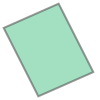

In [71]:
fema_data.iloc[68]['geometry']

In [72]:
fema_data.iloc[68]

BUILD_ID                                                   915522
OCC_CLS                                               Residential
PRIM_OCC                                   Single Family Dwelling
SEC_OCC                                                      None
PROP_ADDR                                                    None
PROP_CITY                                                    None
PROP_ST                                                    Hawaii
PROP_ZIP                                                     None
OUTBLDG                                                      None
HEIGHT                                                        NaN
SQMETERS                                               266.954773
SQFEET                                                2873.474365
H_ADJ_ELEV                                                   None
L_ADJ_ELEV                                                   None
FIPS                                                        15007
CENSUSCODE

In [73]:
# Standardize and collapse addresses in API data
api_data['standardized_address'] = api_data['formattedAddress'].str.lower().replace({'street': 'st', 'road': 'rd'}, regex=True)
api_data['standardized_address'] = api_data['formattedAddress'].str.replace(r'\bapt.*\b|\bunit.*\b', '', regex=True).str.strip()
api_data = api_data.drop_duplicates(subset=['formattedAddress', 'zipCode'])

In [74]:
# Create geometry columns for GeoDataFrames
api_data['geometry'] = api_data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
#fema_data['geometry'] = fema_data.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
building_footprints['geometry'] = building_footprints.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

api_gdf = gpd.GeoDataFrame(api_data, geometry='geometry', crs='EPSG:4326')
fema_gdf = gpd.GeoDataFrame(fema_data, geometry='geometry', crs='EPSG:4326')
building_footprints_gdf = gpd.GeoDataFrame(building_footprints, geometry='geometry', crs='EPSG:4326')



In [75]:
joined = gpd.sjoin(api_gdf, fema_gdf, how="inner", op='intersects')

/Users/kd6801/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [76]:
print(f"After joining the Apartment API and Fema dataset, we have {len(joined)} overlaps.")

After joining the Apartment API and Fema dataset, we have 75 overlaps.


In [77]:
# Rename columns in both dataframes if they exist
if 'index_left' in joined.columns:
    joined.rename(columns={'index_left': 'index_left_old'}, inplace=True)
if 'index_right' in joined.columns:
    joined.rename(columns={'index_right': 'index_right_old'}, inplace=True)
if 'index_left' in building_footprints_gdf.columns:
    building_footprints_gdf.rename(columns={'index_left': 'index_left_old'}, inplace=True)
if 'index_right' in building_footprints_gdf.columns:
    building_footprints_gdf.rename(columns={'index_right': 'index_right_old'}, inplace=True)

In [78]:
# Now we make sure they use the same CRS
print(f"CRS for geoParquet dataframe is {building_footprints_gdf.crs}")
print(f"CRS for joined dataframe is {joined.crs}")
building_footprints_gdf = building_footprints_gdf.set_crs(joined.crs, allow_override=True)
print(f"After alignment,CRS for geoParquet dataframe is {building_footprints_gdf.crs}")
print(f"After alignment,CRS for joined dataframe is {joined.crs}")

print(f"There are in total {len(building_footprints_gdf)} entries in the foot traffic data")

CRS for geoParquet dataframe is EPSG:4326
CRS for joined dataframe is EPSG:4326
After alignment,CRS for geoParquet dataframe is EPSG:4326
After alignment,CRS for joined dataframe is EPSG:4326
There are in total 47954 entries in the foot traffic data


In [79]:
# Check for and drop any geometries that are None or contain NaN coordinates
building_footprints_gdf = building_footprints_gdf[building_footprints_gdf.geometry.notna()]
joined = joined[joined.geometry.notna()]
# Remove any geometries that are invalid
building_footprints_gdf = building_footprints_gdf[building_footprints_gdf.geometry.is_valid]
joined = joined[joined.geometry.is_valid]

In [80]:
# Spatial join API data with FEMA data
joined_gdf = gpd.sjoin(joined, building_footprints_gdf, how='inner', op='intersects')

/Users/kd6801/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [81]:
print(f"Through direct gpd.sjoin, we see that there is {len(joined_gdf)} overlap.")

Through direct gpd.sjoin, we see that there is 0 overlap.


### Need to use  nearest geometry

In [82]:
from shapely.ops import nearest_points

# Prepare an R-tree index on the building footprints
building_index = building_footprints_gdf.sindex

def nearest_building(point, building_gdf, building_index):
    possible_matches_index = list(building_index.nearest(point.bounds, 1))
    possible_matches = building_gdf.iloc[possible_matches_index]
    nearest_geom = nearest_points(point, possible_matches.unary_union)[1]
    return nearest_geom

# Apply the nearest building function to each point in the joined GeoDataFrame
joined_gdf['nearest_building'] = joined_gdf['geometry'].apply(lambda x: nearest_building(x, building_footprints_gdf, building_index))


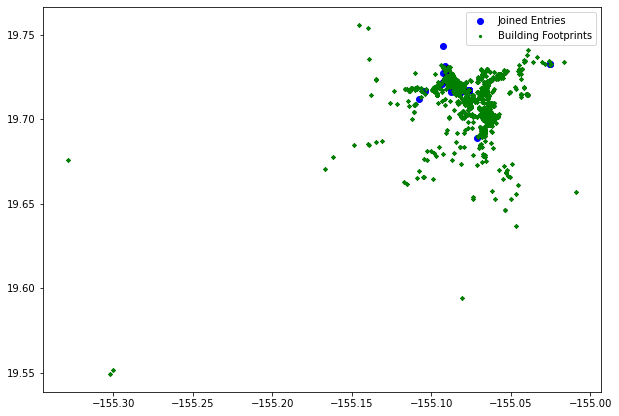

In [83]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
joined.plot(ax=ax, color='blue', label='Joined Entries')
building_footprints_gdf.plot(ax=ax, color='green', label='Building Footprints', markersize=5)
plt.legend()
plt.show()


The plot appears to be a visualization of two sets of geospatial data:

- **Joined Entries (in blue):** These represent the locations where the API data and FEMA data have intersecting points after a spatial join, indicating where apartments identified by the API are matched with FEMA's dataset of building locations.
- **Building Footprints (in green):** These are the locations of buildings as outlined by the footprint data.

What we can deduce from the plot is:

1. **Clustering:** There seems to be a cluster of buildings (green points) where several joined entries (blue points) are located. This suggests a higher density of buildings in certain areas which could correspond to a city center or urban residential area.
   
2. **Spatial Relationship:** The blue points (joined entries) are within or very close to the green points (building footprints), which suggests that the spatial join has been successful to a certain extent, aligning the data from the two different sources.

3. **Coverage:** We are only looking at aprtment buildings, which indicate strong correlation between the hot spot of foot traffic data and apartments in Hilo.

4. **Observation:** If we look at the latitude values (y-axis), we can see the range is quite small, suggesting that this is a localized area.

In [84]:
# import geopandas as gpd
# import contextily as ctx
# import matplotlib.pyplot as plt

# # Ensure that your GeoDataFrame 'joined' has a CRS set
# joined.crs = "EPSG:4326"  # Set it to WGS 84 if it's not already set

# # Convert to EPSG:3857 for mapping
# joined = joined.to_crs(epsg=3857)
# building_footprints_gdf = building_footprints_gdf.to_crs(epsg=3857)

# # Plotting
# fig, ax = plt.subplots(figsize=(10, 10))
# joined.plot(ax=ax, color='blue', label='Joined Entries', markersize=5)
# building_footprints_gdf.plot(ax=ax, color='green', label='Building Footprints', markersize=5)

# try:
#     # Add the basemap with zoom level set
#     ctx.add_basemap(ax, zoom=12, source=ctx.providers.Stamen.TonerLite)  # You might need to adjust the zoom level
# except Exception as e:
#     print("An error occurred while fetching the basemap:", e)

# plt.legend()
# plt.show()


In [85]:
#!pip install contextily


In [86]:
# from shapely.geometry import Point, Polygon
# from pyproj import Proj, Transformer

# # Define projections
# proj_wgs84 = Proj(proj='latlong', datum='WGS84')
# proj_utm = Proj(proj="utm", zone=5, datum='WGS84')  # Adjust zone based on your location

# # Create a transformer
# transformer_to_utm = Transformer.from_proj(proj_wgs84, proj_utm, always_xy=True)
# transformer_to_wgs84 = Transformer.from_proj(proj_utm, proj_wgs84, always_xy=True)

# def buffer_in_meters(lon, lat, meters):
#     """
#     Buffer a geographic point defined in latitude and longitude by a specified distance in meters,
#     transforming it to UTM coordinates for buffering, then converting back to WGS84.

#     Parameters:
#     - lon (float): Longitude of the point in decimal degrees.
#     - lat (float): Latitude of the point in decimal degrees.
#     - meters (float): The buffer distance in meters.

#     Returns:
#     - shapely.geometry.polygon.Polygon or None: A polygon representing the buffered area around the point in WGS84 coordinates.
#       Returns None if the buffered polygon is empty.

#     The function performs coordinate transformations to UTM for accurate distance measurement, buffers the point, and 
#     then transforms the buffered polygon's coordinates back to WGS84 for compatibility with geographic applications. This method 
#     ensures more accurate distance calculations than buffering directly in geographic coordinates.
#     """
#     # Transform point to UTM
#     x, y = transformer_to_utm.transform(lon, lat)
    
#     # Create point and buffer in UTM
#     point_utm = Point(x, y)
#     buffered_point_utm = point_utm.buffer(meters)
    
#     # Convert buffered polygon to WGS84
#     if buffered_point_utm.is_empty:
#         return None
#     else:
#         exterior_coords = [(x, y) for x, y in zip(*buffered_point_utm.exterior.coords.xy)]
#         transformed_coords = [transformer_to_wgs84.transform(x, y) for x, y in exterior_coords]
#         polygon_wgs84 = Polygon(transformed_coords)
#         return polygon_wgs84


In [87]:
# # Call the above function
# building_footprints_gdf['geometry'] = building_footprints_gdf.apply(
#     lambda row: buffer_in_meters(row['longitude'], row['latitude'], 10), axis=1)